In [463]:
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)


from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.graphVAE import GraphVAE
from torch.utils.data import Dataset, Subset
from torch_geometric.utils import to_dense_batch, to_dense_adj
import numpy as np
from src.utils.data_utils import *
from torch_geometric.loader import DataLoader
from src.dataset_classes.graphDataset import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [464]:
dataset = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()
dataset = load_graph_data(dataset, amnino_acids=21)
batch_size = 128
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [480]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/GVAE/FINAL_MODEL/LD32_HD512_Beta0.005_BetaInc0_GCH16_LR0.0001.ckpt"
model = GraphVAE.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


GraphVAE(
  (conv1): GCNConv(21, 16)
  (conv2): GCNConv(16, 32)
  (fc_mu): Linear(in_features=16000, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=16000, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=512, bias=True)
  (fc2_dec_feature): Linear(in_features=512, out_features=10500, bias=True)
  (fc_adj_dec): Linear(in_features=32, out_features=16000, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (soft): Softmax(dim=-1)
)

In [481]:
batch_test = next(iter(loader))
torch.sum(batch_test.x.argmax(-1) == 0)

tensor(37630)

In [482]:
labels = []
latent_coord = []
model.eval()
total_samples = []
lengths = []
i_amino_count = {i:[] for i in range(21)}
for batch_i, batch in enumerate(loader):
    for batch_sample in range(batch.batch[-1]+1):
        lengths.append(torch.sum(batch[batch_sample].x).int().item())
    # for i in range(21):
    #     i_amino_count[i].extend(torch.sum(batch.argmax(-1) == i, axis = -1))
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [483]:
latent_coord.shape

(28733, 32)

In [484]:
import umap
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

# Apply UMAP
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(latent_coord)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


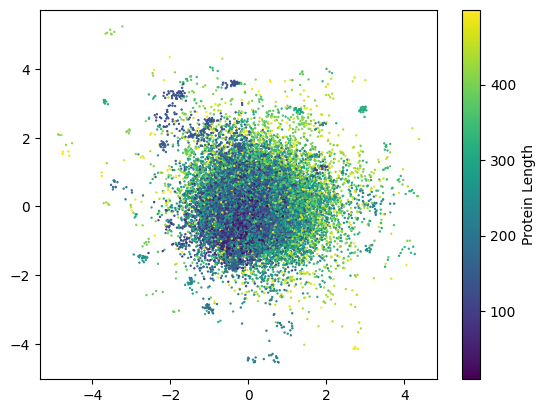

In [485]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
import matplotlib.pyplot as plt

plt.scatter(latent_coord[:, 0], latent_coord[:, 1], s = 0.5, c = lengths, cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.show()
# plt.savefig("exp_1_latent_Pfam.png")

### SAMPLE FROM MODEL

In [486]:
batch_sample = next(iter(loader))
batch_out = model(batch_sample)

#### Forward out: reparam_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix
#### Decode out: z, logit_feature_matrix, adj_matrix

In [487]:
idx = 66
rec, logit_feature, adj_matrix = model.decode(batch_out[1])

In [488]:
start_mean = batch_out[1][idx]
start_std = batch_out[2][idx]

point_interpolates = []

for i in range(0,3):
    point_interpolates.append(start_mean + start_std*(i))


In [489]:
model_interpolate_reconstructions = []

for sample in point_interpolates:
    output = model.decode(sample)
    model_interpolate_reconstructions.append(output)

In [490]:
model_interpolate_reconstructions[0][0].squeeze().argmax(dim=-1).shape

torch.Size([500])

### Compare Feature Matrix Graphs

In [491]:
x_true_indices = batch_sample[idx].x.argmax(dim=-1)
x_true_indices[torch.where(torch.sum(batch_sample[idx].x, dim = -1) == 0)] = -1
end_idx = torch.where(x_true_indices != -1)[-1][-1].item()
original = batch_sample[idx].x.argmax(dim=-1)[:]
sequence_vectors = [original]

for model_int in model_interpolate_reconstructions:
    sequence_vectors.append(model_int[0].squeeze().argmax(dim = -1)[:])

In [492]:
torch.where(sequence_vectors[0] == 20)

(tensor([], dtype=torch.int64),)

In [493]:
difference_vectors = np.array([(seq_vec == x_true_indices).to(torch.int).numpy() for seq_vec in sequence_vectors])

RuntimeError: a Tensor with 5 elements cannot be converted to Scalar

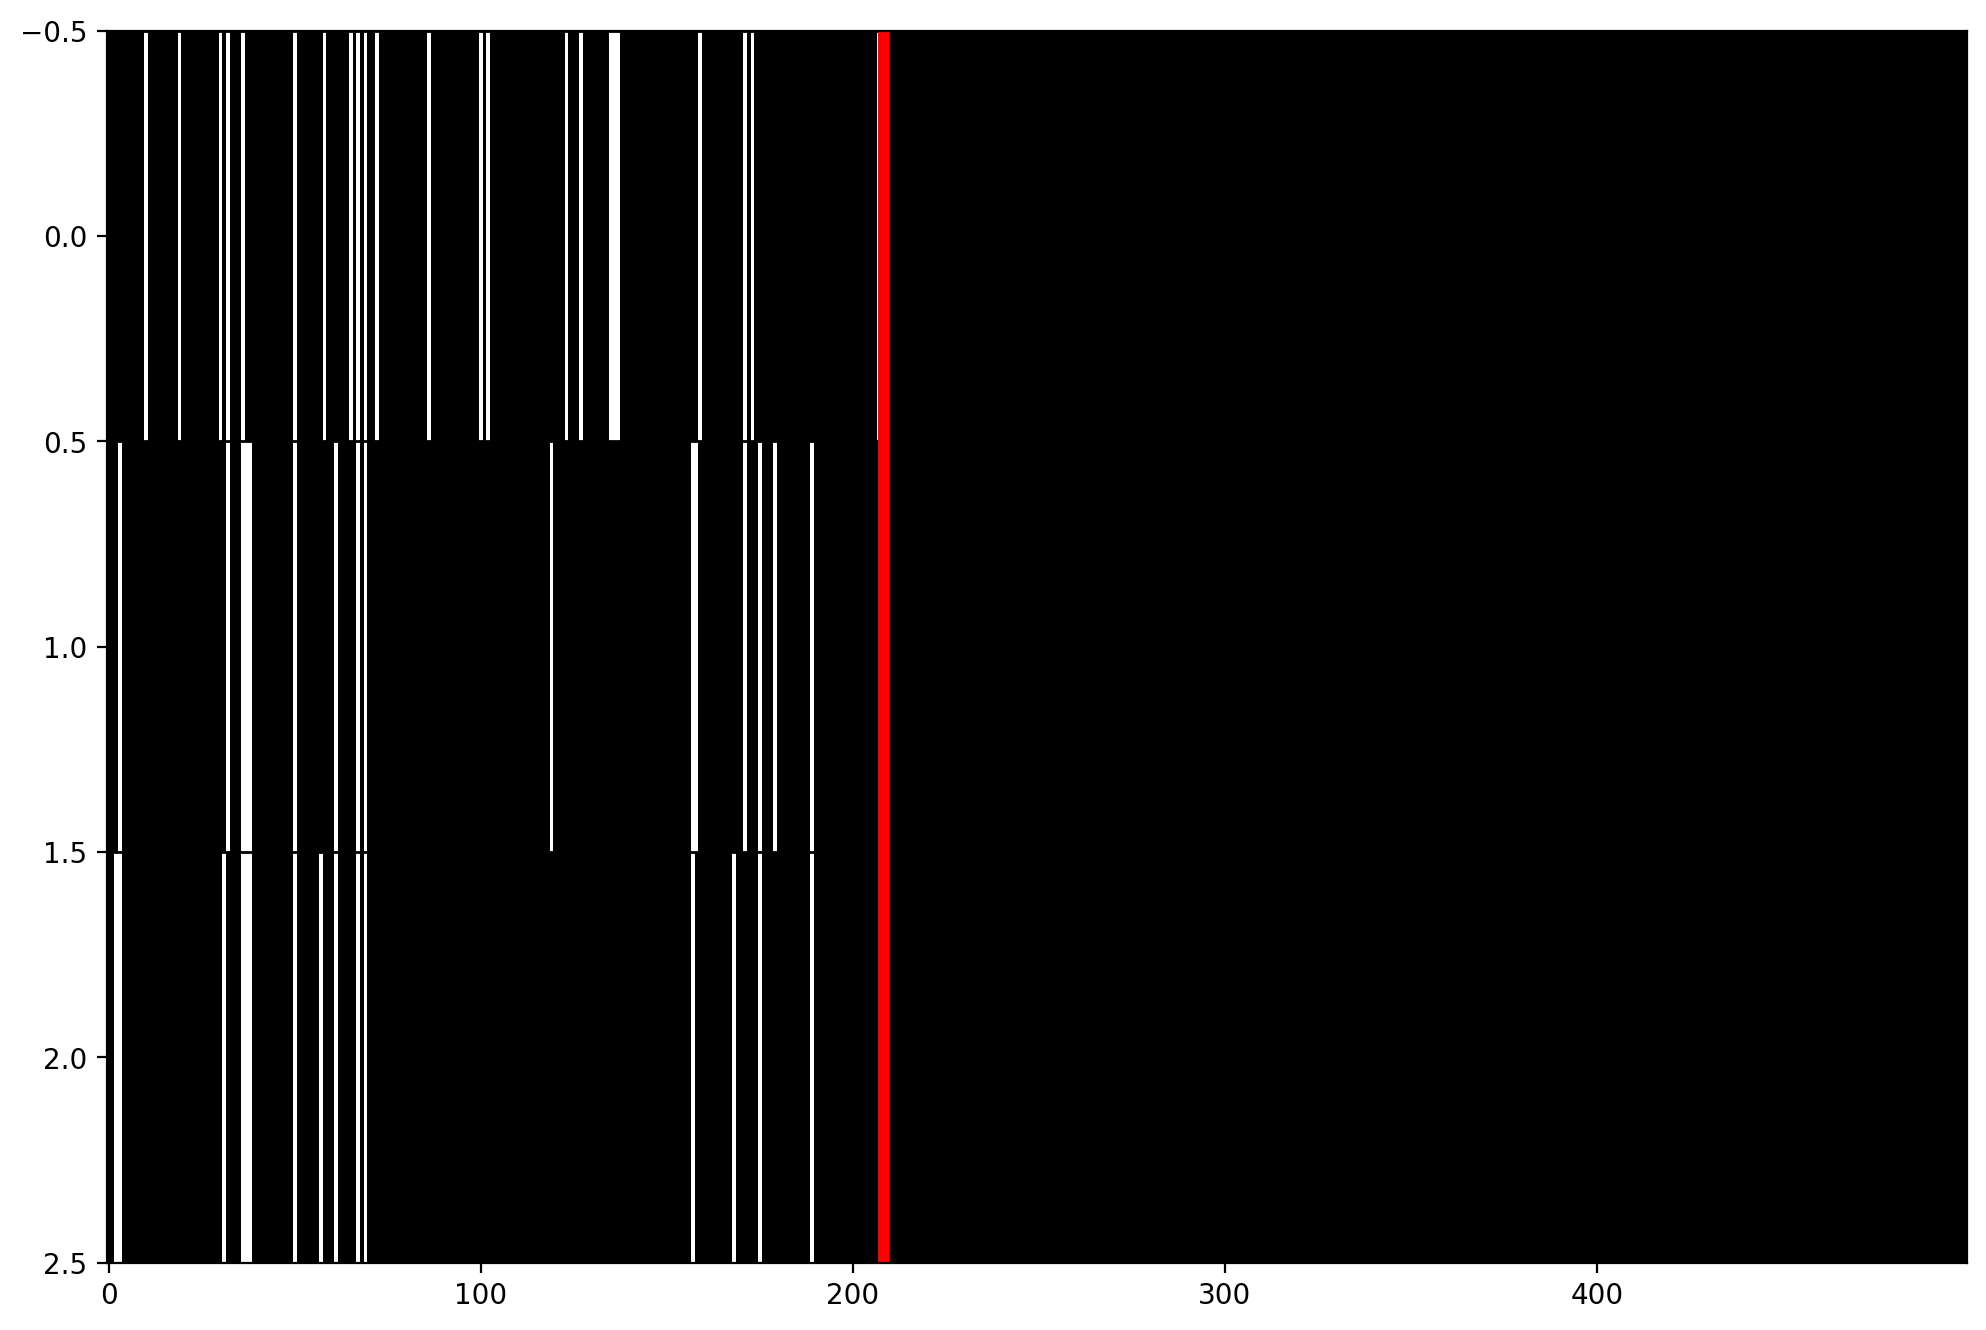

In [494]:
# Create a DataFrame with random values
# Generate random data
data = difference_vectors[1:,:] #end_idx+10]  # 6x6 matrix

fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)  # Adjust size here
# cmap = plt.cm.colors.ListedColormap(["red", "black"])
# Display heatmap
cax = ax.imshow(data, cmap='grey', aspect="auto")
# plt.colorbar(cax)

for i in range(data.shape[0]):
    ax.hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="black", linewidth=1)

yticks = [0, 0.5, 1]

for i in range(len(sequence_vectors)-1):

    if i == 0:
        ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
    else:
        prop_idx = torch.where(sequence_vectors[i] == 20)[0].item()
        if i == 1:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')
        else:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4)

# plt.yticks(range(data.shape[0]), yticks)
ax.tick_params(axis='both', labelsize=14) 
plt.ylabel('Stand. Dev. from Original Sample in Latent Space', fontsize = 16)
plt.title("Sequence Generation Interpolation - Graph VAE", fontsize = 18)
plt.xlabel('Sequence Index', fontsize = 16)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()


### Compare Adjacency Matrices

In [ ]:
x_true_indices = batch_sample[idx].x.argmax(dim=-1)
x_true_indices[torch.where(torch.sum(batch_sample[idx].x, dim = -1) == 0)] = -1
end_idx = torch.where(x_true_indices != -1)[-1][-1].item()
original =  to_dense_adj(batch_sample[idx].edge_index, max_num_nodes=500).squeeze()
original_adj_matrices = []
adj_matrices = []

for model_int in model_interpolate_reconstructions:
    # If equal they will be set to one
    original_adj_matrices.append(torch.round(model_int[-1].squeeze()))
    comparison = (torch.round(model_int[-1].squeeze()) == (original + torch.eye(original.shape[0]))).to(torch.int)

    # If both are non zero at the same point they will be set to one
    # not_zero_out = (torch.round(model_int[-1].squeeze()) != 0).to(torch.int)
    # not_zero_true = ((original + torch.eye(original.shape[0])) != 0).to(torch.int)
    # not_zero = (not_zero_true == not_zero_out).to(torch.int)

    # comparison = not_zero
    adj_matrices.append(comparison.to(torch.int))

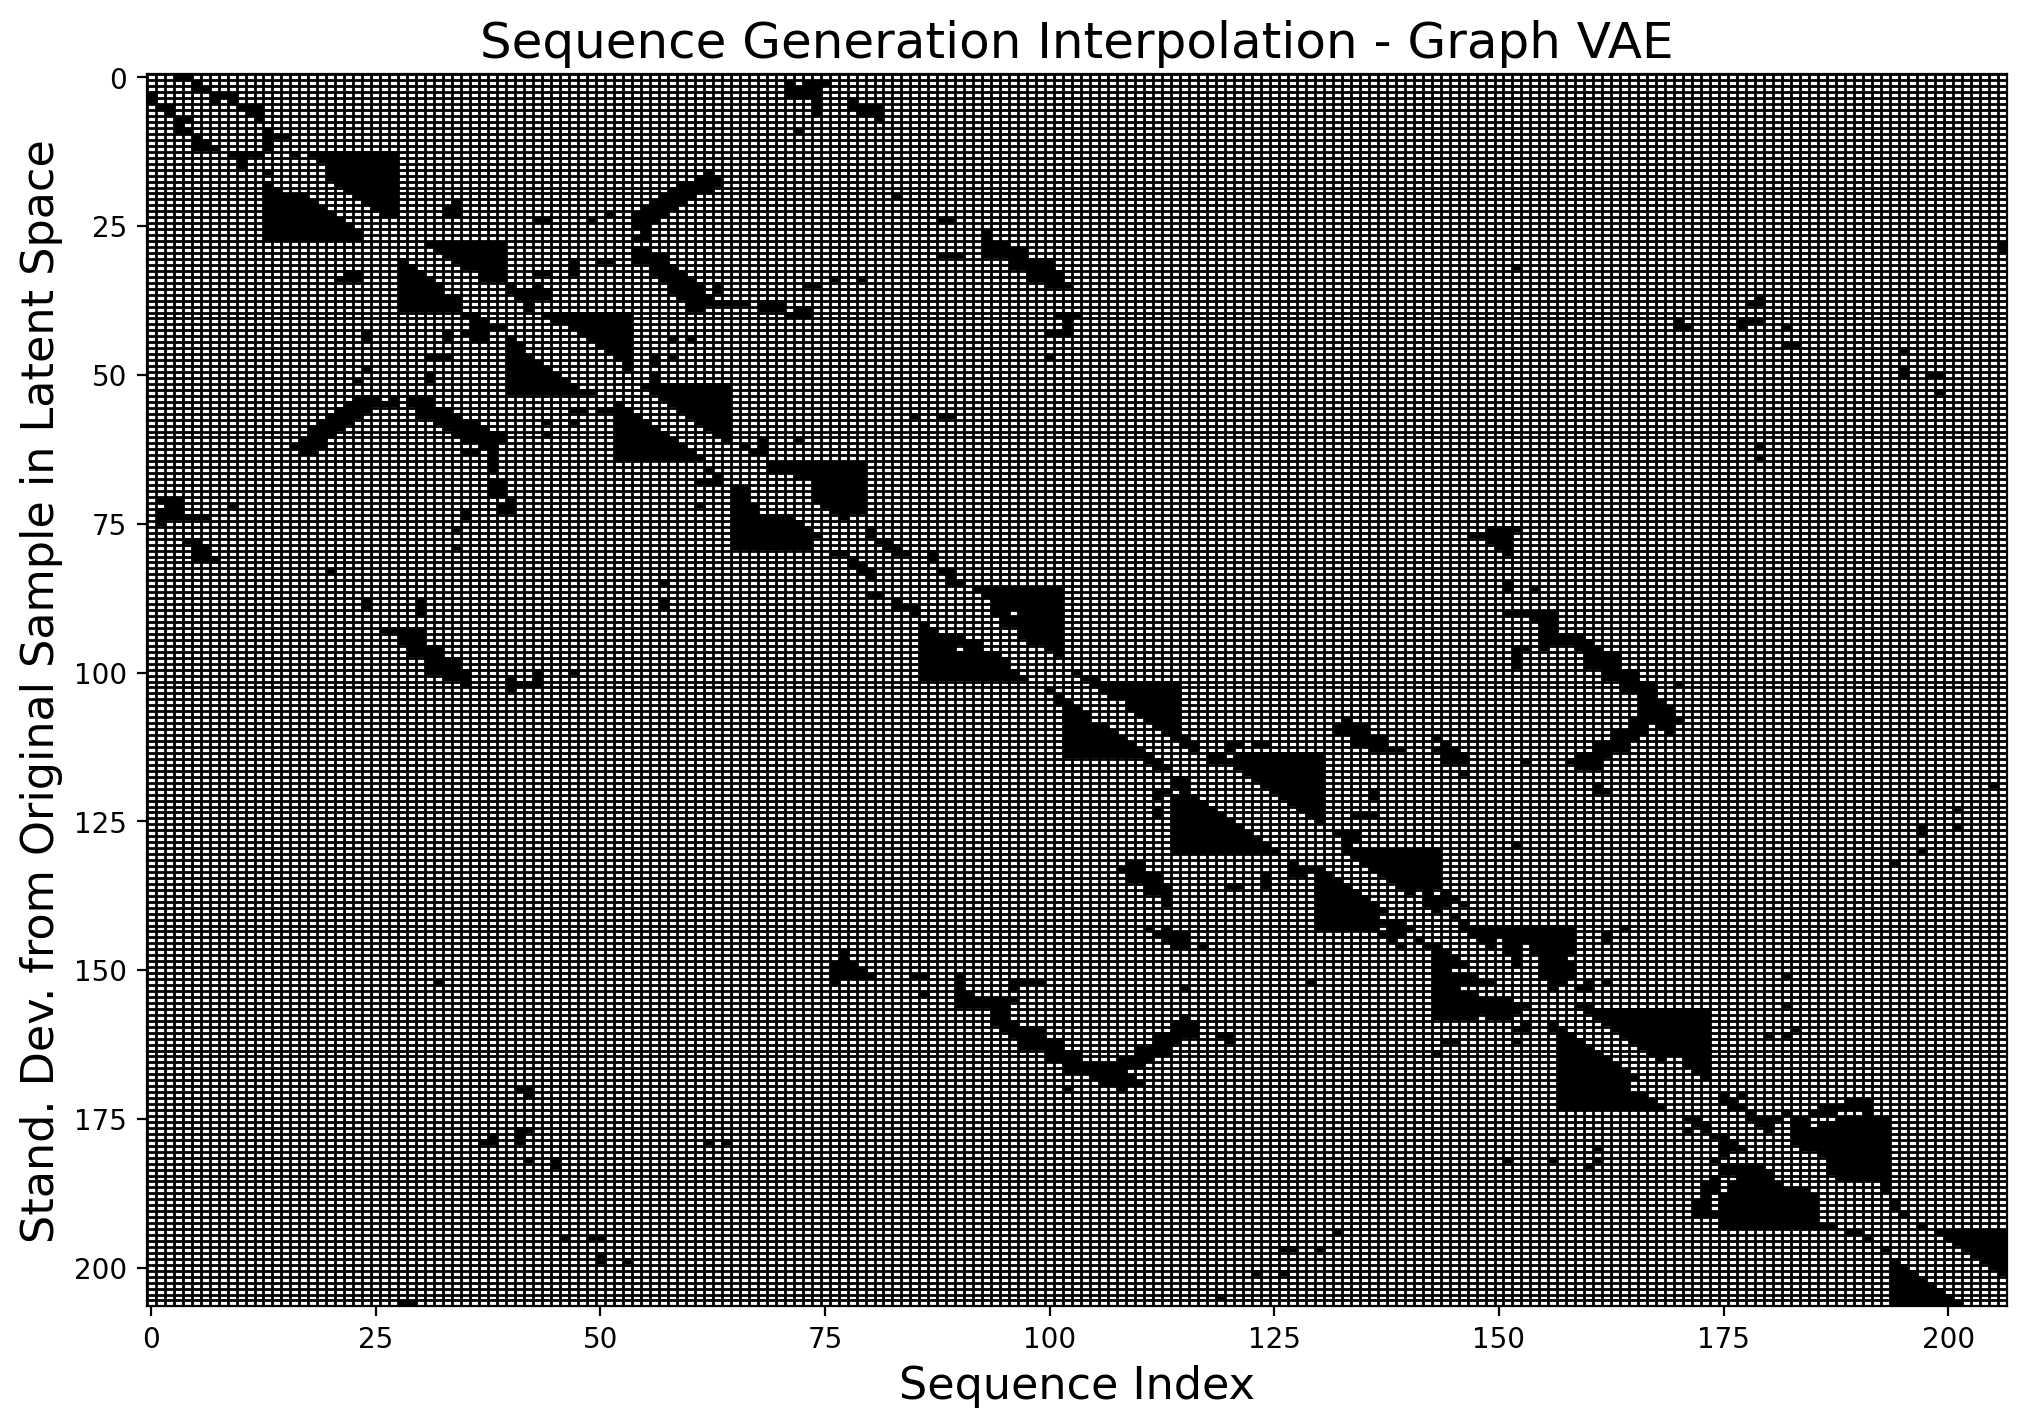

In [444]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)  # Adjust size here
# cmap = plt.cm.colors.ListedColormap(["red", "black"])
# Display heatmap
adj_idx = 1

data = adj_matrices[adj_idx].numpy()[:end_idx, :end_idx]
cmap = mcolors.ListedColormap(['blue', 'green', 'red']) 
bounds = [0, 1, 2, 3]  # Boundaries for the values 0, 1, and 2
norm = mcolors.BoundaryNorm(bounds, cmap.N) 
cax = ax.imshow(data, cmap='grey', aspect="auto")
# plt.colorbar(cax)

for i in range(data.shape[0]):
    ax.hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="black", linewidth=1)
    ax.vlines(i - 0.5, -0.5, data.shape[0] - 0.5, color="black", linewidth=1)

yticks = [0, 0.5, 1]
# ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
# ax.vlines([end_idx+1, end_idx+1], ymin = -0.5, ymax = 0.5, color='b', linestyle='-', linewidth=4)
# ax.vlines([260, 260], ymin = 0.5, ymax = 2.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')

# plt.yticks(range(data.shape[0]), yticks)
# ax.tick_params(axis='both', labelsize=14) 
plt.ylabel('Stand. Dev. from Original Sample in Latent Space', fontsize = 16)
plt.title("Sequence Generation Interpolation - Graph VAE", fontsize = 18)
plt.xlabel('Sequence Index', fontsize = 16)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

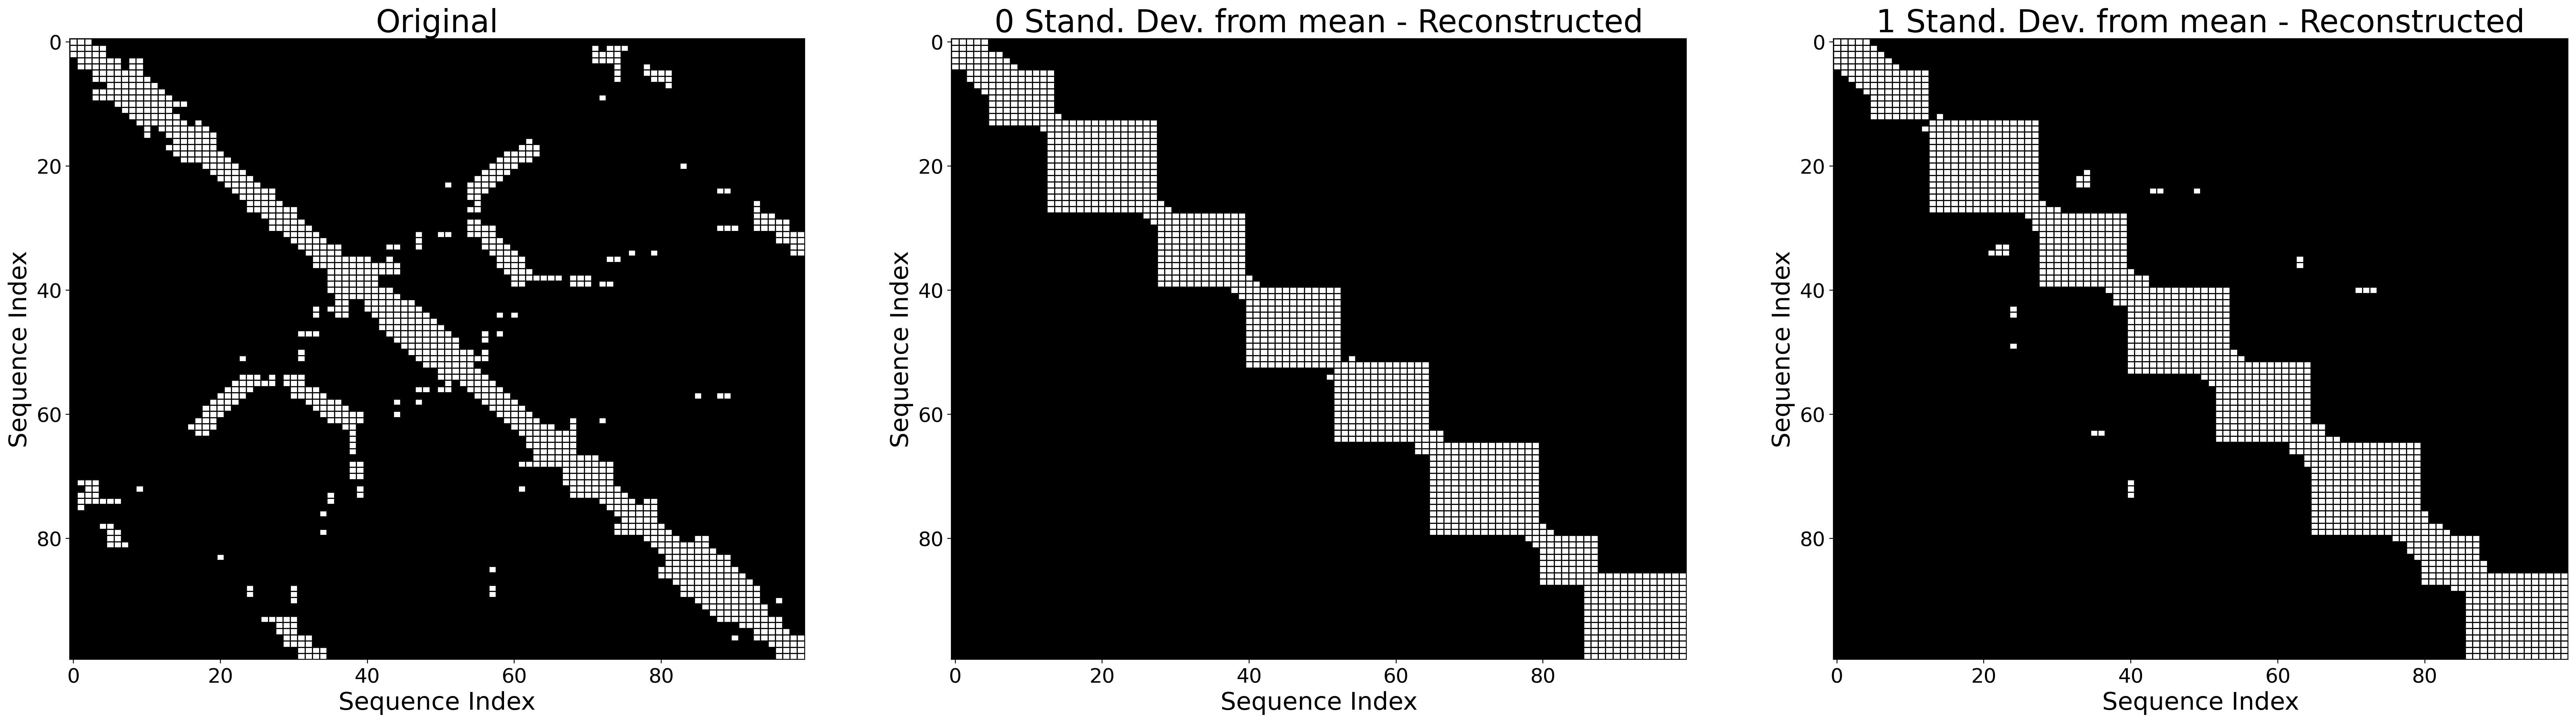

In [445]:
import matplotlib.colors as mcolors
end_idx = 100
data = ((original + torch.eye(original.shape[0]))).to(torch.int)[:end_idx, :end_idx]
cmap = mcolors.ListedColormap(['blue', 'green', 'red']) 
bounds = [0, 1, 2, 3]  # Boundaries for the values 0, 1, and 2
fig, ax = plt.subplots(1,3, figsize=(40, 10), dpi = 200)  

for j in range(3):
    # cmap = plt.cm.colors.ListedColormap(["red", "black"])
    # Display heatmap
    adj_idx = j
    if j == 0:
        data = ((original + torch.eye(original.shape[0]))).to(torch.int)[:end_idx, :end_idx]
        ax[j].set_title('Original', fontsize = 28)
    else:
        ax[j].set_title(f'{j-1} Stand. Dev. from mean - Reconstructed', fontsize = 28)
        data = original_adj_matrices[adj_idx - 1].detach().numpy()[:end_idx, :end_idx]

    ax[j].set_ylabel('Sequence Index', fontsize = 22)
    ax[j].set_xlabel('Sequence Index', fontsize = 22)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    cax = ax[j].imshow(data, cmap='grey', aspect="auto")
    # plt.colorbar(cax)

    for i in range(data.shape[0]):
        ax[j].hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="black", linewidth=1)
        ax[j].vlines(i - 0.5, -0.5, data.shape[0] - 0.5, color="black", linewidth=1)

    


    # ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
    # ax.vlines([end_idx+1, end_idx+1], ymin = -0.5, ymax = 0.5, color='b', linestyle='-', linewidth=4)
    # ax.vlines([260, 260], ymin = 0.5, ymax = 2.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')

    # plt.yticks(range(data.shape[0]), yticks)
    # ax.tick_params(axis='both', labelsize=14) 
    # plt.ylabel('Sequence Index', fontsize = 16)
    # plt.title("Adjacency Matrix Generation Interpolation - Original Matrix", fontsize = 18)
    # plt.xlabel('Sequence Index', fontsize = 16)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)


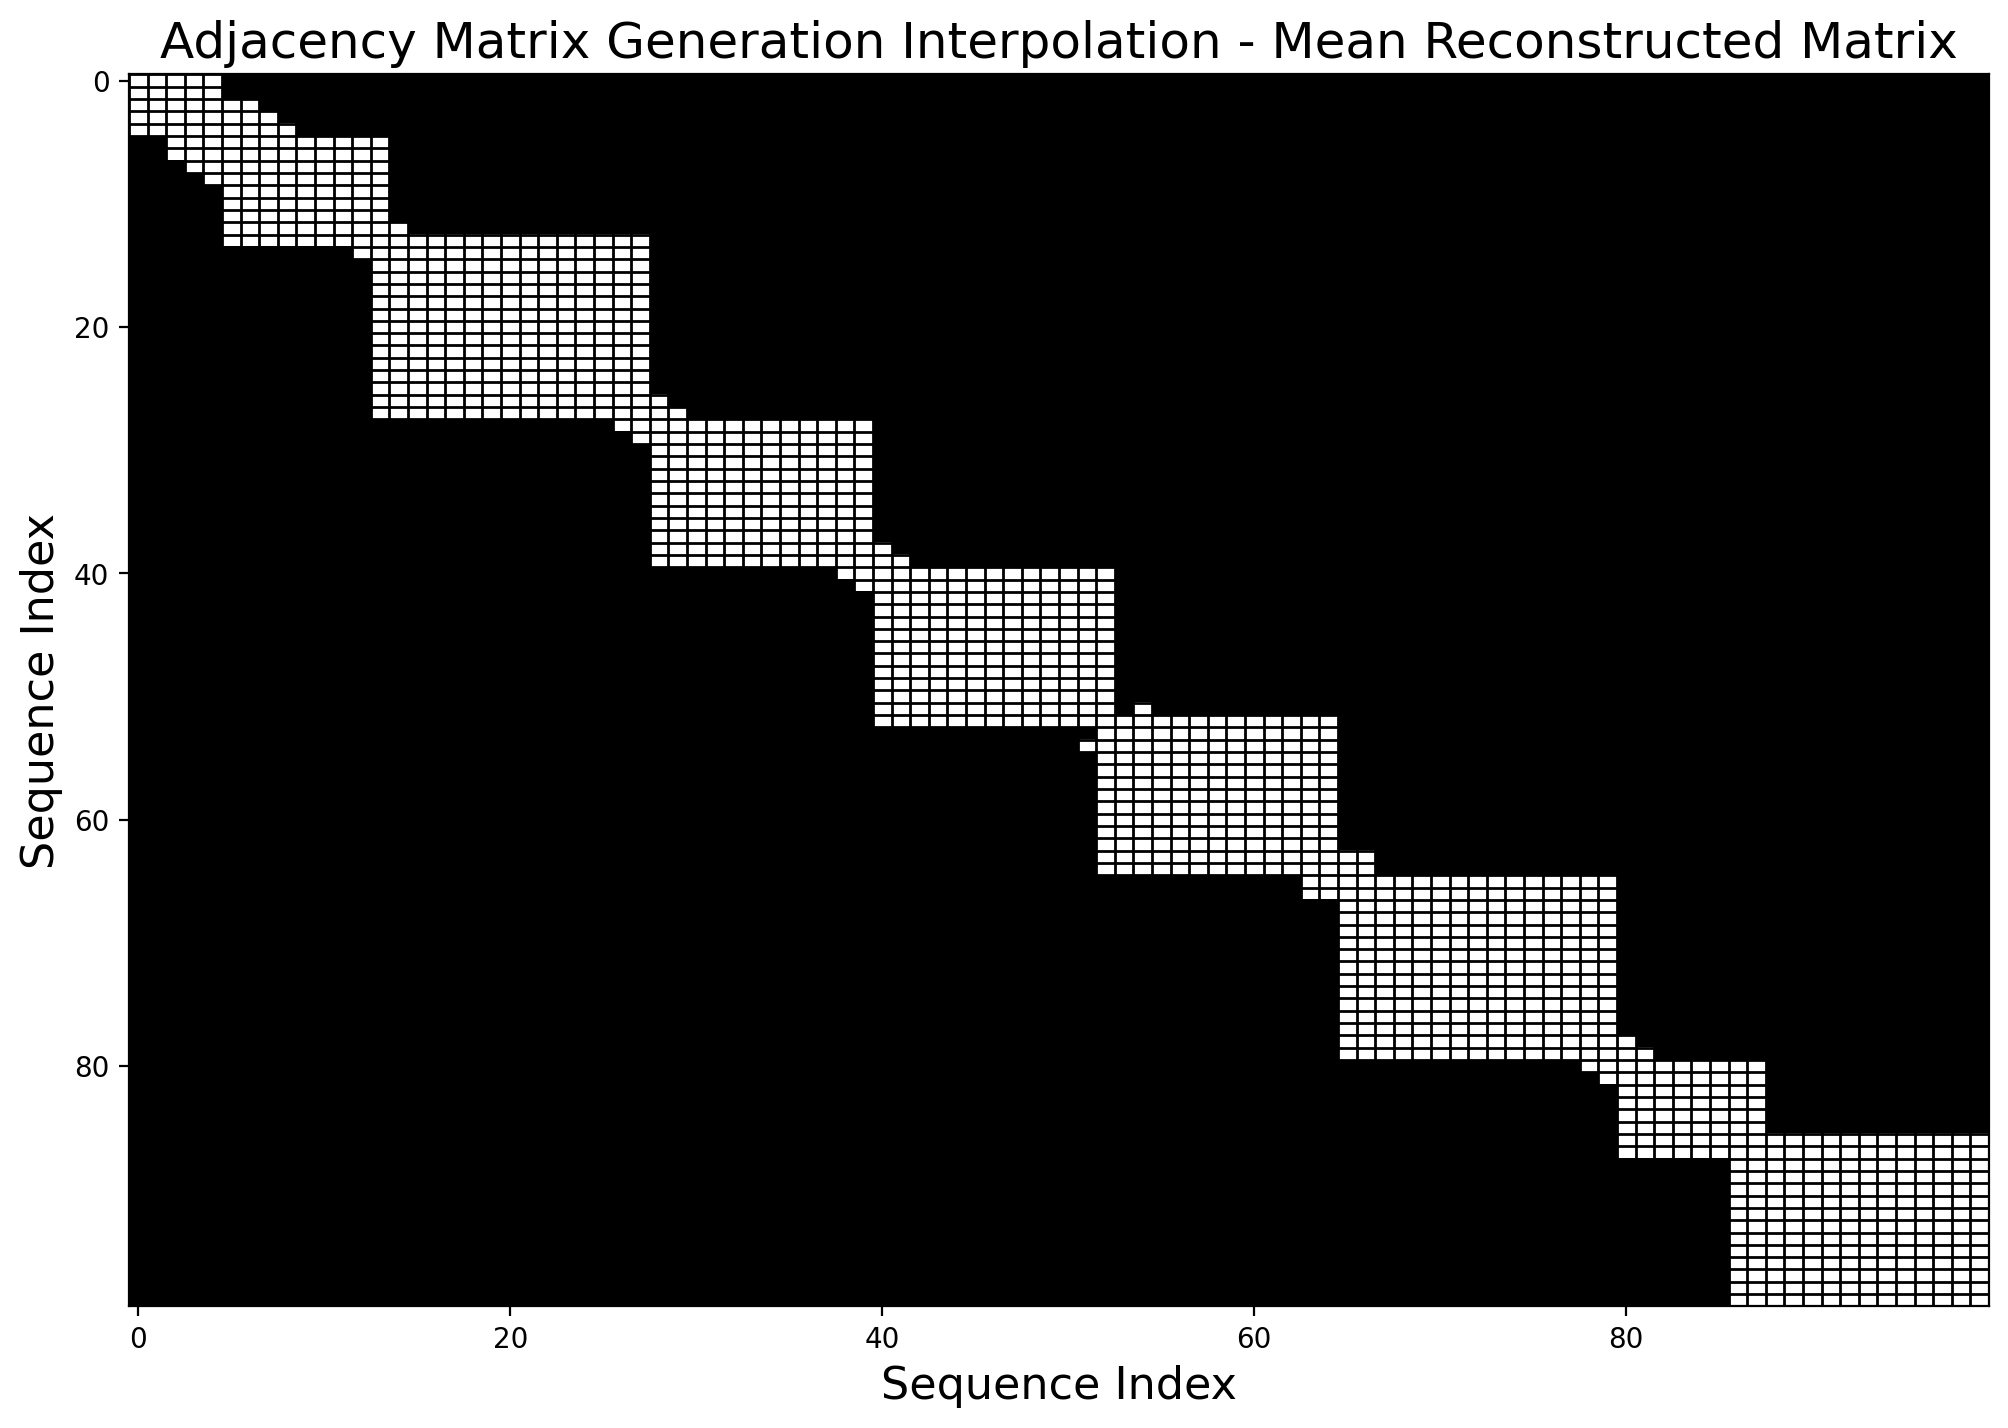

In [446]:
fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)  # Adjust size here
# cmap = plt.cm.colors.ListedColormap(["red", "black"])
# Display heatmap
adj_idx = 0

data = original_adj_matrices[adj_idx].detach().numpy()[:end_idx, :end_idx]
cmap = mcolors.ListedColormap(['blue', 'green', 'red']) 
bounds = [0, 1, 2, 3]  # Boundaries for the values 0, 1, and 2
norm = mcolors.BoundaryNorm(bounds, cmap.N) 
cax = ax.imshow(data, cmap='grey', aspect="auto")
# plt.colorbar(cax)

for i in range(data.shape[0]):
    ax.hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="black", linewidth=1)
    ax.vlines(i - 0.5, -0.5, data.shape[0] - 0.5, color="black", linewidth=1)

yticks = [0, 0.5, 1]
# ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
# ax.vlines([end_idx+1, end_idx+1], ymin = -0.5, ymax = 0.5, color='b', linestyle='-', linewidth=4)
# ax.vlines([260, 260], ymin = 0.5, ymax = 2.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')

# plt.yticks(range(data.shape[0]), yticks)
# ax.tick_params(axis='both', labelsize=14) 
plt.ylabel('Sequence Index', fontsize = 16)
plt.title("Adjacency Matrix Generation Interpolation - Mean Reconstructed Matrix", fontsize = 18)
plt.xlabel('Sequence Index', fontsize = 16)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()